In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from scipy.optimize import curve_fit
from neo.core import AnalogSignal
from neuronunit.tests import TimeConstantTest

In [2]:
def make_sweep(total_time,amplitude,offset_time,tau):
    # Construct x and y without an exponential signal
    sampling_rate = 10000*pq.Hz # samples per ms
    total_samples = (total_time * sampling_rate).simplified
    assert total_samples.dimensionality == pq.dimensionless
    total_samples = int(total_samples)
    noise_sigma = 0.3*pq.mV
    times = np.linspace(0,float(total_time),total_samples)*pq.ms
    vm = AnalogSignal(noise_sigma*np.random.randn(total_samples),
                     times=times,
                     sampling_rate=sampling_rate.rescale(1/pq.ms))

    # Add the exponential signal
    samples_until_offset = (offset_time * sampling_rate).simplified
    assert samples_until_offset.dimensionality == pq.dimensionless
    samples_until_offset = int(samples_until_offset)
    exponential = amplitude*np.exp(-(times[samples_until_offset:]-offset_time)/tau)
    vm[samples_until_offset:,0] += exponential.reshape(-1,1)
    return vm

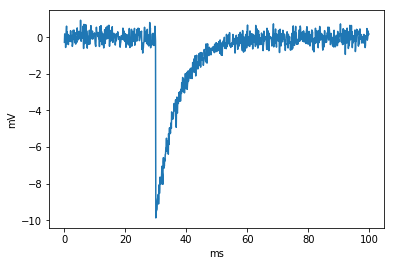

In [3]:
total_time = 100*pq.ms
amplitude = -10*pq.mV
offset_time = 30*pq.ms
tau = 7*pq.ms
    
vm = make_sweep(total_time,amplitude,offset_time,tau)

plt.plot(vm.times.rescale('ms'),vm)
plt.xlabel(pq.ms.symbol)
plt.ylabel(pq.mV.symbol);

In [4]:
test = TimeConstantTest(observation={'mean':tau, 'std':np.sqrt(float(tau))*tau.units})
i = {'duration':total_time, 'delay':offset_time}
tau_estimated = test.get_tau(vm,i).round(3)
print("Estimated tau = %s; Actual tau = %s" % (tau_estimated,tau))

Estimated tau = 6.907 ms; Actual tau = 7.0 ms


In [5]:
assert 0.95 < tau_estimated/tau < 1.05